In [7]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from datetime import date, timedelta

In [73]:
sdate = date(2017, 1, 1)   # start date
#edate = date.today()      # end date

edate = date.today()  # end date

delta = edate - sdate      # as timedelta

date_list = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    date_list.append(day.strftime("%d/%m/%Y"))
    
date_list[:5]

['01/01/2017', '02/01/2017', '03/01/2017', '04/01/2017', '05/01/2017']

In [3]:
json_list = []
for day in date_list:
    payload = {'idZona':'7',
               'data':day}
    r = requests.get('http://servizos.meteogalicia.es/rss/observacion/listaEstacionsCA.action',
                 params=payload)
    json_list.append(r.json())

In [115]:
for i, json_file in enumerate(json_list):
    fecha = json_file['datosZona'][0]['fecha']
    formatted_fecha = pd.to_datetime(fecha, dayfirst=True).date()
    filename = "./jsons/dia_{}.json".format(formatted_fecha)
    with open(filename, 'w') as open_file:
        json.dump(json_file, open_file)

In [162]:
json_list[0]['datosZona'][0]

{'fecha': '01/01/2017',
 'hora': '13:00',
 'icas': [{'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'SO2',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.01'},
  {'calculo': 'O',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'CO',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.028'},
  {'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'NO2',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.19'},
  {'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'PM10',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.36'},
  {'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'O3',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.17'},
  {'calculo': 'H',
   'estacion': '

In [174]:
def read_hour(hour):
    meas_dict = {
        ('Vigo - Coia', 'SO2'):'SO2_c',
        ('Vigo - Coia', 'CO'):'CO_c',
        ('Vigo - Coia', 'NO2'):'NO2_c',
        ('Vigo - Coia', 'PM10'):'PM10_c',
        ('Vigo - Coia', 'O3'):'O3_c',
        ('Vigo - Lope de Vega', 'SO2'):'SO2_ldv',
        ('Vigo - Lope de Vega', 'CO'):'CO_ldv',
        ('Vigo - Lope de Vega', 'NO2'):'NO2_ldv',
        ('Vigo - Lope de Vega', 'PM10'):'PM10_ldv',
        ('Vigo - Lope de Vega', 'O3'):'O3_ldv'
    }
    values_dict = {}
    for key, value in meas_dict.items():
        values_dict[value] = 0
    for ica in hour['icas']:
        values_dict[meas_dict[(ica['estacion'], ica['parametro'])]] = float(ica['valorIca'])
    return values_dict
        
def read_day(day):
    value_list = []
    for hour in day:
        values = [value for key, value in read_hour(hour).items()]
        value_list.append(values)
    try:
        return np.mean(np.array(value_list), axis=0)
    except TypeError:
        return value_list

print(read_hour(json_list[125]['datosZona'][0]))
print()
print(read_hour(json_list[84]['datosZona'][9]))

read_day(json_list[84]['datosZona'])

{'SO2_c': 0.01, 'CO_c': 0.04, 'NO2_c': 0.27, 'PM10_c': 0.15, 'O3_c': 0.41, 'SO2_ldv': 0, 'CO_ldv': 0, 'NO2_ldv': 0, 'PM10_ldv': 0, 'O3_ldv': 0}

{'SO2_c': 0.01, 'CO_c': 0.048, 'NO2_c': 0.19, 'PM10_c': 0.11, 'O3_c': 0.28, 'SO2_ldv': 0.0, 'CO_ldv': 0.015, 'NO2_ldv': 0.24, 'PM10_ldv': 0.17, 'O3_ldv': 0.41}


array([0.01033333, 0.04104167, 0.13166667, 0.10495833, 0.45208333,
       0.0025    , 0.01341667, 0.15166667, 0.07616667, 0.55      ])

In [144]:
#for json_file in json_list:
#    for hour in json_file['datosZona']:
#        ica_pairs = [(ica['estacion'], ica['parametro']) for ica in hour['icas']]
#        print(ica_pairs)
#        #hour['icas'] = [i for n, i in enumerate(hour['icas']) if i not in hour['icas'][n + 1:]]

In [148]:
for i, day in enumerate(json_list):
    try:
        get_mean(day['datosZona'])
    except:
        print(i)

125
127
437
438
442
448
449
461
463
676
729
772
807
808
924
925
959
960
976
978
979
981
993
995


In [194]:
raw_data = []
dates = []
for i, day in enumerate(json_list):
    try:
        row = read_day(day['datosZona'])
        raw_data.append(row)
        dates.append(json_list[i]['datosZona'][0]['fecha'])
    except TypeError:
        print("{} failed".format(i))
    #row = []
    #row.append(json_list[i]['datosZona'][0]['fecha'])
    #for meas in json_list[i]['datosZona'][0]['icas']:
    #    [x for x in json_list[i]['datosZona']]
    #    row.append(meas['valorIca'])
    #row.insert(0, json_list[i]['datosZona'][0]['fecha'])

print(len(dates))
print(len(raw_data))
    
df = pd.DataFrame(raw_data,
                  columns=[
                     'SO2_c',
                     'CO_c',
                     'NO2_c',
                     'PM10_c',
                     'O3_c',
                     'SO2_ldv',
                     'CO_ldv',
                     'NO2_ldv',
                     'PM10_ldv',
                     'O3_ldv',
                     ],
                    dtype='float')
df.insert(0, 'data', pd.to_datetime(dates, dayfirst=True))
df.head()

1176
1176


,data,SO2_c,CO_c,NO2_c,PM10_c,O3_c,SO2_ldv,CO_ldv,NO2_ldv,PM10_ldv,O3_ldv
0,2017-01-01,0.01472,0.05496,0.35360,0.57200,0.11612,0.0,0.03900,0.27000,0.41440,0.16000
1,2017-01-02,0.00896,0.02420,0.18480,0.27172,0.26180,0.0,0.03900,0.27000,0.23316,0.16120
2,2017-01-03,0.00844,0.01308,0.17668,0.15216,0.31040,0.0,0.02684,0.18264,0.13408,0.33000
3,2017-01-04,0.00640,0.01664,0.24464,0.14296,0.15484,0.0,0.04028,0.23368,0.13180,0.18436
4,2017-01-05,0.00900,0.03044,0.32000,0.22200,0.06024,0.0,0.05040,0.26000,0.18828,0.10096


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   data      1176 non-null   datetime64[ns]
 1   SO2_c     1176 non-null   float64       
 2   CO_c      1176 non-null   float64       
 3   NO2_c     1176 non-null   float64       
 4   PM10_c    1176 non-null   float64       
 5   O3_c      1176 non-null   float64       
 6   SO2_ldv   1176 non-null   float64       
 7   CO_ldv    1176 non-null   float64       
 8   NO2_ldv   1176 non-null   float64       
 9   PM10_ldv  1176 non-null   float64       
 10  O3_ldv    1176 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 101.2 KB


In [196]:
for col in df.columns[1:]:
    df.loc[df[col] <= 0, col] = None
df.interpolate()
df.fillna(df.mean(), inplace=True)
df

,data,SO2_c,CO_c,NO2_c,PM10_c,O3_c,SO2_ldv,CO_ldv,NO2_ldv,PM10_ldv,O3_ldv
0,2017-01-01,0.01472,0.05496,0.35360,0.57200,0.11612,0.017543,0.03900,0.27000,0.41440,0.16000
1,2017-01-02,0.00896,0.02420,0.18480,0.27172,0.26180,0.017543,0.03900,0.27000,0.23316,0.16120
2,2017-01-03,0.00844,0.01308,0.17668,0.15216,0.31040,0.017543,0.02684,0.18264,0.13408,0.33000
3,2017-01-04,0.00640,0.01664,0.24464,0.14296,0.15484,0.017543,0.04028,0.23368,0.13180,0.18436
4,2017-01-05,0.00900,0.03044,0.32000,0.22200,0.06024,0.017543,0.05040,0.26000,0.18828,0.10096
...,...,...,...,...,...,...,...,...,...,...,...
1171,2020-03-17,0.01720,0.01300,0.09104,0.11268,0.45360,0.008800,0.01512,0.06896,0.11464,0.40672
1172,2020-03-18,0.02604,0.01300,0.16772,0.14364,0.30960,0.009600,0.03036,0.08900,0.15500,0.26796
1173,2020-03-19,0.03284,0.01300,0.19736,0.25560,0.23152,0.013040,0.02984,0.09872,0.25000,0.19504
1174,2020-03-20,0.02340,0.01300,0.06208,0.21680,0.44440,0.013920,0.01592,0.02940,0.27760,0.38360


In [184]:
df.to_csv('./since_2017.csv')

(0, 1)

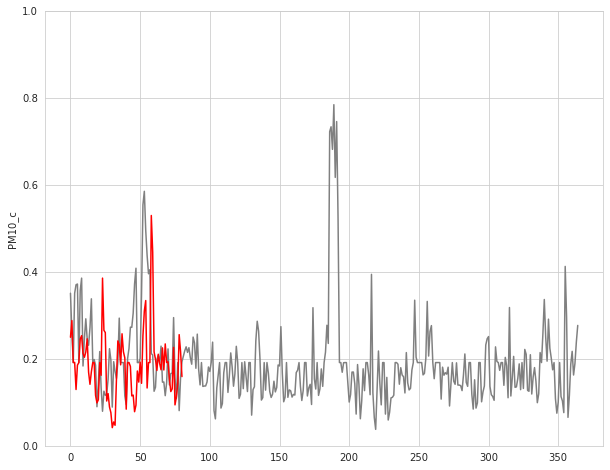

In [209]:
gas = 'PM10_c'
fig, ax = plt.subplots(figsize=(10,8))
#ax = sns.lineplot(data=df[df['data'].dt.year == 2017], x=range(365), y=gas, color='grey')
#ax = sns.lineplot(data=df[df['data'].dt.year == 2018], x=range(365), y=gas, color='grey')
ax = sns.lineplot(data=df[df['data'].dt.year == 2019], x=range(365), y=gas, color='grey')
ax = sns.lineplot(data=df[df['data'].dt.year == 2020], x=range(df[df['data'].dt.year == 2020].shape[0]),
                  y=gas, color='red')
ax.set_ylim(0, 1)